In [2]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

Populating the interactive namespace from numpy and matplotlib


In [3]:
import spectools_ir
spectools_ir.__file__

'/Users/erichegonzales/opt/anaconda3/lib/python3.8/site-packages/spectools_ir/__init__.py'

In [4]:
hitran_data=extract_hitran_data('CO',4.58,5.2,vup=1)  #Outputs an astropy table
#Read in FITS data containing spectrum.

# Transitional Disks

#CI Tau data
citau_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/nirspec_citau_glue.dat'  #my file name
citau_wave, citau_flux = np.loadtxt(citau_infile, unpack=True, skiprows=21)

#LkHa 330 data
lkha330_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/nirspec_lkha330_glue.dat'  #my file name
lkha330_wave, lkha330_flux = np.loadtxt(lkha330_infile, unpack=True, skiprows=30)

#TW Hya data
twhya_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/nirspec_twhya_glue.dat'  #my file name
twhya_wave, twhya_flux = np.loadtxt(twhya_infile, unpack=True, skiprows=46)

#DoAr 44 data
doar44_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/nirspec_doar44_glue.dat'  #my file name
doar44_wave, doar44_flux = np.loadtxt(doar44_infile, unpack=True, skiprows=29)

#HD 135344 data
hd135344_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/nirspec_hd135344_glue.dat'  #my file name
hd135344_wave, hd135344_flux = np.loadtxt(hd135344_infile, unpack=True, skiprows=25)

#UX Tau data
uxtau_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/nirspec_uxtau_glue.dat'  #my file name
uxtau_wave, uxtau_flux = np.loadtxt(uxtau_infile, unpack=True, skiprows=25)

# Classical Disks

#DoAr 24 data
doar24_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/classical_disks/nirspec_doar24es_glue.dat'  #my file name
doar24_wave, doar24_flux = np.loadtxt(doar24_infile, unpack=True, skiprows=21)

#DF Tau data
dftau_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/classical_disks/nirspec_dftau_glue.dat'  #my file name
dftau_wave, dftau_flux = np.loadtxt(dftau_infile, unpack=True, skiprows=21)

#DL Tau data
dltau_infile='/Users/erichegonzales/Desktop/eriche-thesis/data/classical_disks/nirspec_dltau_glue.dat'  #my file name
dltau_wave, dltau_flux = np.loadtxt(dltau_infile, unpack=True, skiprows=21)

# Compare Spectra

#Plot spectrum of transitional disks, separate later
fig=plt.figure(figsize=(18,8))

#Disks wavelengths within range of 4.645 - 4.785
ax1=fig.add_subplot(211)

#Transitional Disks
ax1.plot(citau_wave, citau_flux, label='Ci Tau')
ax1.plot(lkha330_wave, lkha330_flux, label='LkHa 330')
ax1.plot(twhya_wave, twhya_flux, label='TW Hya')
ax1.plot(doar44_wave, doar44_flux, label='DoAr 44')
ax1.plot(hd135344_wave, hd135344_flux, label='HD 135344')
ax1.plot(uxtau_wave, uxtau_flux, label='UX Tau')

#Classical Disks
ax1.plot(doar24_wave, doar24_flux, label='DoAr 24')
ax1.plot(dftau_wave, dftau_flux, label='DF Tau')
ax1.plot(dltau_wave, dltau_flux, label='DL Tau')

#Range
ax1.set_xlim(4.645,4.785)
ax1.set_ylim(-0.5,4.5)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.645) & (mywave<4.785) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],4.2,hitran_data['Qpp'][i].strip())
        
    
#Labels
ax1.set_ylabel('Flux [Jy]',fontsize=14)
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=2)
ax1.set_title('Composite Lineshape of Classical Disks')


#Disks wavelengths within range of 4.95 - 5.10
ax2=fig.add_subplot(212)

#Transitional Disks
ax2.plot(citau_wave, citau_flux, label='Ci Tau')
ax2.plot(lkha330_wave, lkha330_flux, label='LkHa 330')
ax2.plot(twhya_wave, twhya_flux, label='TW Hya')
ax2.plot(doar44_wave, doar44_flux, label='DoAr 44')
ax2.plot(hd135344_wave, hd135344_flux, label='HD 135344')
ax2.plot(uxtau_wave, uxtau_flux, label='UX Tau')

#Classical Disks
ax2.plot(doar24_wave, doar24_flux, label='DoAr 24')
ax2.plot(dftau_wave, dftau_flux, label='DF Tau')
ax2.plot(dltau_wave, dltau_flux, label='DL Tau')


ax2.set_xlim(4.95,5.10)
ax2.set_ylim(-0.5,4.5)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.95) & (mywave<5.10) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],4.2,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)
#ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=2)
ax2.set_title('Composite Lineshape of Classical Disks')

Text(0.5, 1.0, 'Composite Lineshape of Classical Disks')

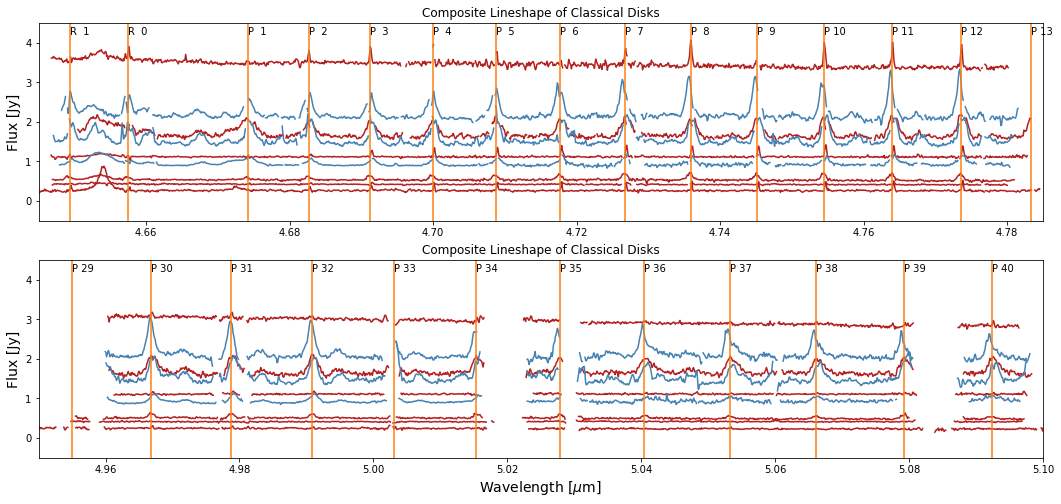

In [35]:
# Both Transitional and Classical

#Plot spectrum of transitional disks, separate later
fig=plt.figure(figsize=(18,8))

#Disks wavelengths within range of 4.645 - 4.785
ax1=fig.add_subplot(211)

#Transitional Disks
ax1.plot(citau_wave, citau_flux, label='Ci Tau', color='firebrick')
ax1.plot(lkha330_wave, lkha330_flux, label='LkHa 330', color='firebrick')
ax1.plot(twhya_wave, twhya_flux, label='TW Hya', color='firebrick')
ax1.plot(doar44_wave, doar44_flux, label='DoAr 44', color='firebrick')
ax1.plot(hd135344_wave, hd135344_flux, label='HD 135344', color='firebrick')
ax1.plot(uxtau_wave, uxtau_flux, label='UX Tau', color='firebrick')

#Classical Disks
ax1.plot(doar24_wave, doar24_flux, label='DoAr 24', color='steelblue')
ax1.plot(dftau_wave, dftau_flux, label='DF Tau', color='steelblue')
ax1.plot(dltau_wave, dltau_flux, label='DL Tau', color='steelblue')

#Range
ax1.set_xlim(4.645,4.785)
ax1.set_ylim(-0.5,4.5)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.645) & (mywave<4.785) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],4.2,hitran_data['Qpp'][i].strip())
        
    
#Labels
ax1.set_ylabel('Flux [Jy]',fontsize=14)
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=2)
ax1.set_title('Composite Lineshape of Classical Disks')


#Disks wavelengths within range of 4.95 - 5.10
ax2=fig.add_subplot(212)

#Transitional Disks
ax2.plot(citau_wave, citau_flux, label='Ci Tau', color='firebrick')
ax2.plot(lkha330_wave, lkha330_flux, label='LkHa 330', color='firebrick')
ax2.plot(twhya_wave, twhya_flux, label='TW Hya', color='firebrick')
ax2.plot(doar44_wave, doar44_flux, label='DoAr 44', color='firebrick')
ax2.plot(hd135344_wave, hd135344_flux, label='HD 135344', color='firebrick')
ax2.plot(uxtau_wave, uxtau_flux, label='UX Tau', color='firebrick')

#Classical Disks
ax2.plot(doar24_wave, doar24_flux, label='DoAr 24', color='steelblue')
ax2.plot(dftau_wave, dftau_flux, label='DF Tau', color='steelblue')
ax2.plot(dltau_wave, dltau_flux, label='DL Tau', color='steelblue')


ax2.set_xlim(4.95,5.10)
ax2.set_ylim(-0.5,4.5)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.95) & (mywave<5.10) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],4.2,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)
#ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=2)
ax2.set_title('Composite Lineshape of Classical Disks')

Text(0.5, 1.0, 'Composite Lineshape of Transitional Disks')

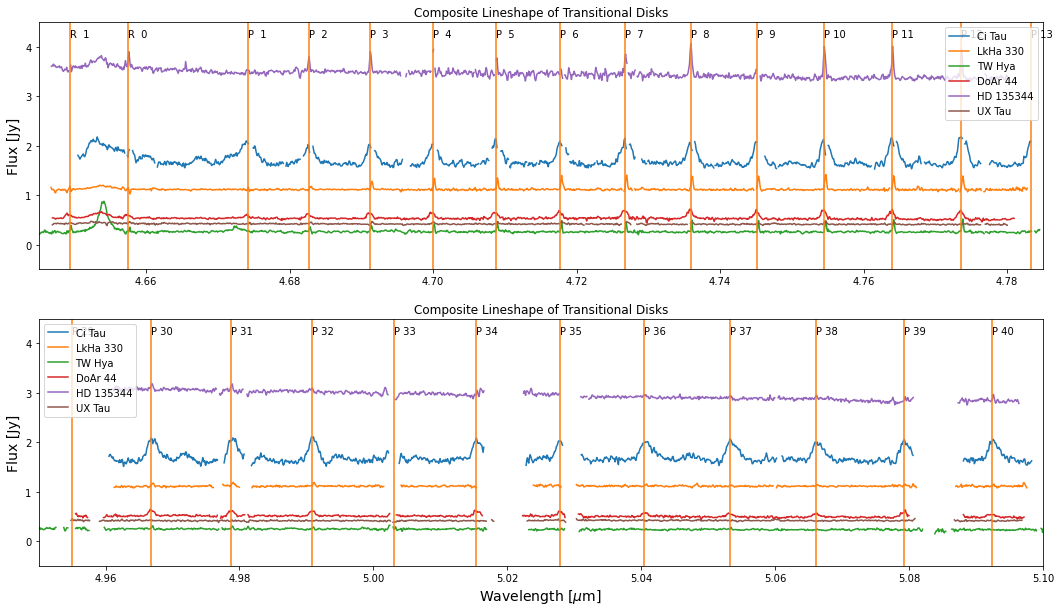

In [12]:
#Transitional Disks

#Plot spectrum of transitional disks
fig=plt.figure(figsize=(18, 10))

#Disks wavelengths within range of 4.645 - 4.785
ax1=fig.add_subplot(211)

#Transitional Disks
ax1.plot(citau_wave, citau_flux, label='Ci Tau')
ax1.plot(lkha330_wave, lkha330_flux, label='LkHa 330')
ax1.plot(twhya_wave, twhya_flux, label='TW Hya')
ax1.plot(doar44_wave, doar44_flux, label='DoAr 44')
ax1.plot(hd135344_wave, hd135344_flux, label='HD 135344')
ax1.plot(uxtau_wave, uxtau_flux, label='UX Tau')

#Range
ax1.set_xlim(4.645,4.785)
ax1.set_ylim(-0.5,4.5)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.645) & (mywave<4.785) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],4.2,hitran_data['Qpp'][i].strip())
        
    
#Labels
ax1.set_ylabel('Flux [Jy]',fontsize=14)
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=2)
ax1.legend()
ax1.set_title('Composite Lineshape of Transitional Disks')


#Disks wavelengths within range of 4.95 - 5.10
ax2=fig.add_subplot(212)

#Transitional Disks
ax2.plot(citau_wave, citau_flux, label='Ci Tau')
ax2.plot(lkha330_wave, lkha330_flux, label='LkHa 330')
ax2.plot(twhya_wave, twhya_flux, label='TW Hya')
ax2.plot(doar44_wave, doar44_flux, label='DoAr 44')
ax2.plot(hd135344_wave, hd135344_flux, label='HD 135344')
ax2.plot(uxtau_wave, uxtau_flux, label='UX Tau')

ax2.set_xlim(4.95,5.10)
ax2.set_ylim(-0.5,4.5)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.95) & (mywave<5.10) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],4.2,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)
#ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=2)
ax2.legend()
ax2.set_title('Composite Lineshape of Transitional Disks')

Text(0.5, 1.0, 'Composite Lineshape of Classical Disks')

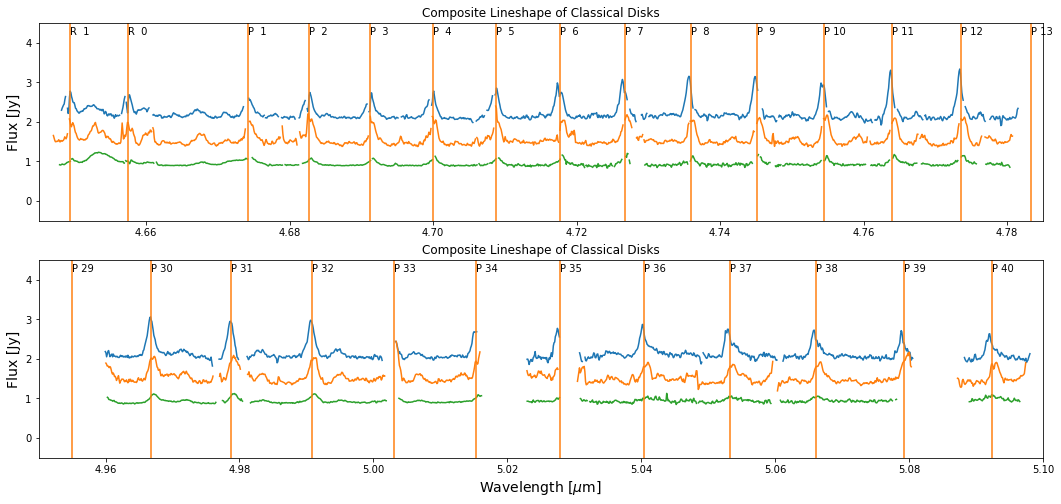

In [6]:
#Classical Disks

#Plot spectrum of classical disks
fig=plt.figure(figsize=(18,8))

#Disks wavelengths within range of 4.645 - 4.785
ax1=fig.add_subplot(211)

#Classical Disks
ax1.plot(doar24_wave, doar24_flux, label='DoAr 24')
ax1.plot(dftau_wave, dftau_flux, label='DF Tau')
ax1.plot(dltau_wave, dltau_flux, label='DL Tau')

#Range
ax1.set_xlim(4.645,4.785)
ax1.set_ylim(-0.5,4.5)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.645) & (mywave<4.785) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],4.2,hitran_data['Qpp'][i].strip())
        
    
#Labels
ax1.set_ylabel('Flux [Jy]',fontsize=14)
#ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=2)
ax1.set_title('Composite Lineshape of Classical Disks')


#Disks wavelengths within range of 4.95 - 5.10
ax2=fig.add_subplot(212)

#Classical Disks
ax2.plot(doar24_wave, doar24_flux, label='DoAr 24')
ax2.plot(dftau_wave, dftau_flux, label='DF Tau')
ax2.plot(dltau_wave, dltau_flux, label='DL Tau')


ax2.set_xlim(4.95,5.10)
ax2.set_ylim(-0.5,4.5)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.95) & (mywave<5.10) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],4.2,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)
#ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.6), ncol=2)
ax2.set_title('Composite Lineshape of Classical Disks')

# Compare Composite Lineshapes

In [7]:
#Transitional Disks

#CI Tau data
citau_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/citau_lineflux_data.p','rb'))
citau_lineshape_data=make_lineshape(citau_wave, citau_flux, citau_lineflux_data)

#LkHa 330 data
lkha330_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/lkha330_lineflux_data.p','rb'))
lkha330_lineshape_data=make_lineshape(lkha330_wave, lkha330_flux, lkha330_lineflux_data)

#TW Hya data
twhya_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/twhya_lineflux_data.p','rb'))
twhya_lineshape_data=make_lineshape(twhya_wave, twhya_flux, twhya_lineflux_data)

#DoAr 44 data
doar44_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/doar44_lineflux_data.p','rb'))
doar44_lineshape_data=make_lineshape(doar44_wave, doar44_flux, doar44_lineflux_data)

#HD 135344 data
hd135344_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/hd135344_lineflux_data.p','rb'))
hd135344_lineshape_data=make_lineshape(hd135344_wave, hd135344_flux, hd135344_lineflux_data)

#UX Tau data
uxtau_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/transitional_disks/uxtau_lineflux_data.p','rb'))
uxtau_lineshape_data=make_lineshape(uxtau_wave, uxtau_flux, uxtau_lineflux_data)

#Classical Disks

#DoAr 24 data
doar24_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/classical_disks/doar24_lineflux_data.p','rb'))
doar24_lineshape_data=make_lineshape(doar24_wave, doar24_flux, doar24_lineflux_data)

#DF Tau data
dftau_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/classical_disks/dftau_lineflux_data.p','rb'))
dftau_lineshape_data=make_lineshape(dftau_wave, dftau_flux, dftau_lineflux_data)

#DL Tau data
dltau_lineflux_data=pickle.load(open('/Users/erichegonzales/Desktop/eriche-thesis/data/classical_disks/dltau_lineflux_data.p','rb'))
dltau_lineshape_data=make_lineshape(dltau_wave, dltau_flux, dltau_lineflux_data)

(0.0, 4.0)

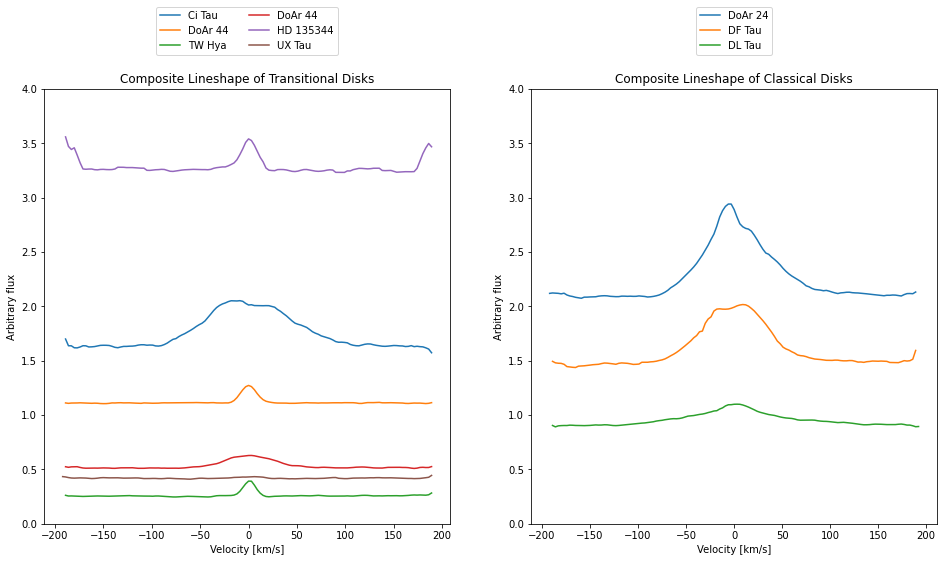

In [20]:
#Plotting composite lineshapes
fig=plt.figure(figsize=(16,8))
ax1=fig.add_subplot(121)
ax1.plot(citau_lineshape_data[0], citau_lineshape_data[1], label='Ci Tau')
ax1.plot(lkha330_lineshape_data[0], lkha330_lineshape_data[1], label='DoAr 44')
ax1.plot(twhya_lineshape_data[0], twhya_lineshape_data[1], label='TW Hya')
ax1.plot(doar44_lineshape_data[0], doar44_lineshape_data[1], label='DoAr 44')
ax1.plot(hd135344_lineshape_data[0], hd135344_lineshape_data[1], label='HD 135344')
ax1.plot(uxtau_lineshape_data[0], uxtau_lineshape_data[1], label='UX Tau')

#Setting labels, limits, legend
ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')
ax1.set_title('Composite Lineshape of Transitional Disks')
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
ax1.set_ylim(0, 4)

#Plotting composite lineshapes
ax2=fig.add_subplot(122)
ax2.plot(doar24_lineshape_data[0], doar24_lineshape_data[1], label='DoAr 24')
ax2.plot(dftau_lineshape_data[0], dftau_lineshape_data[1], label='DF Tau')
ax2.plot(dltau_lineshape_data[0], dltau_lineshape_data[1], label='DL Tau')

#Setting labels, limits, legend
ax2.set_xlabel('Velocity [km/s]')
ax2.set_ylabel('Arbitrary flux')
ax2.set_title('Composite Lineshape of Classical Disks')
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=1)
ax2.set_ylim(0, 4)

# Compare Star Properties and Parameters 

In [60]:
data = pd.read_csv("/Users/erichegonzales/Desktop/eriche-thesis/data/star_data.csv")
print(data)

       object     disk_type  parallax    distance  distance_au  solar_mass  \
0      CI Tau  Transitional   6.23760  160.318071  33068006.93        0.92   
1    LkHa 330  Transitional   3.14250  318.217979  65637231.50        2.50   
2      TW Hya  Transitional  16.62890   60.136269  12404007.48        0.70   
3     DoAr 44  Transitional   6.83430  146.320764  30180852.46        1.40   
4   HD 135344  Transitional   7.41050  134.943661  27834154.24        1.80   
5      UX Tau  Transitional   6.92270  144.452309  29795455.53        1.10   
6      AB Aur         HAeBe   6.41270  155.940555  32165078.67        2.40   
7    HD144432         HAeBe   6.45810  154.844304  31938960.38        1.80   
8    HD 36112         HAeBe   6.41570  155.867637  32150038.19        2.00   
9      GK Tau     Classical   7.74330  129.143905  26637867.58        0.79   
10     RNO 90     Classical   8.72880  114.563285  23630395.93        1.00   
11    DoAr 24     Classical   7.39370  135.250281  27897399.14  

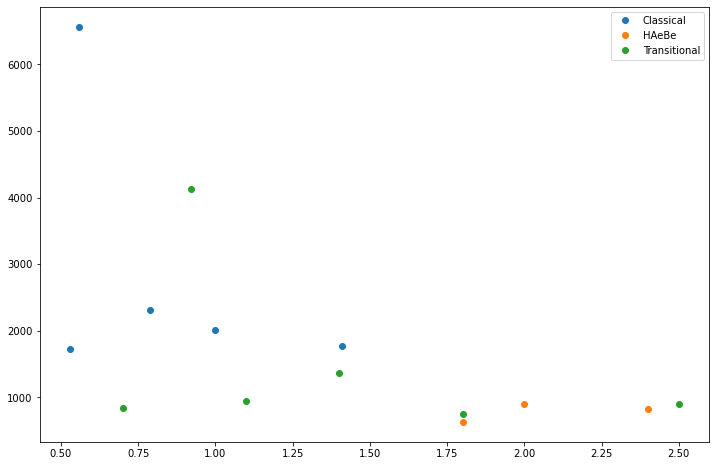

In [77]:
fig=plt.figure(figsize=(12,8))
markers = ['x', 'o', '^']
groups = data.groupby("disk_type")
for name, group in groups:
    plt.plot(group["solar_mass"], group["temp"], marker='o', linestyle="", label=name)
plt.legend()

In [86]:
data
mass_t = data['solar_mass'][data['disk_type'] == 'Transitional']
radius_t = data['disk_radius'][data['disk_type'] == 'Transitional']

print(mass_t)

0    0.92
1    2.50
2    0.70
3    1.40
4    1.80
5    1.10
Name: solar_mass, dtype: float64


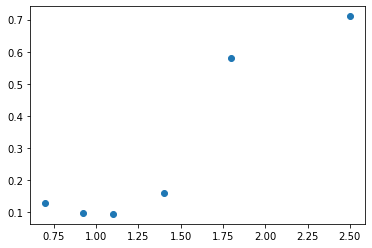

In [87]:
plt.scatter(mass_t, radius_t)

In [84]:
(data.loc[data['disk_type'] == 'Transitional'])['solar_mass']

0    0.92
1    2.50
2    0.70
3    1.40
4    1.80
5    1.10
Name: solar_mass, dtype: float64

In [89]:
data_t = data.loc[data['disk_type'] == 'Transitional']
data_c = data.loc[data['disk_type'] == 'Classical']
data_h = data.loc[data['disk_type'] == 'Herbig']

(0.0, 3000.0)

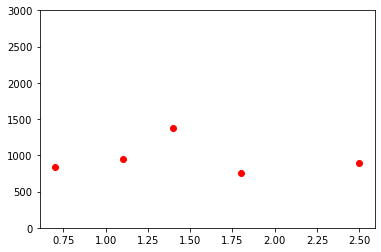

In [92]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(data_t['solar_mass'], data_t['temp'], 'ro')
ax.set_ylim(0,3000)